In [22]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib

# for interactive plots in Jupyter:
# matplotlib.use('qtagg')

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from transform_filter_data import transform_filter_data

In [23]:
# history_len: 365, 270, 180, 90 days
# span_threshold: 90, 60, 40, 20 days

# trained on 2022-05-28 cutoff (for PHYS)
# validated on 2022-11-19 cutoff (for PHYS)
#                                           ACC    f1-0  f1-1
# 1 year:   model always says '0' (testing: 0.902, 0.93, 0.82)
# 9 months: model always says '0' (testing: 0.906, 0.94, 0.82)
# 6 months: model always says '0' (testing: 0.898, 0.94, 0.69)
# 3 months: 0.871, 0.93, 0.00     (testing: 0.886, 0.93, 0.64)

history_len = pd.Timedelta('365 days')
span_threshold = pd.Timedelta('90 days')
accesses_threshold = 30
source_csv = (
    '/home/mshubin/Desktop/datasets-popularity-task-data/' +
    #'datasets_popularity_DAOD_HIGGD_mc16_13TeV_202309211655.csv'
    'datasets_popularity_DAOD_PHYS_mc16_13TeV_202308141254.csv'
)
finish_date_train_test = pd.Timestamp('2022-05-28')
finish_date_validate = pd.Timestamp('2022-11-19')
horizon = pd.Timedelta('7 days')
Ntest = 300

In [24]:
objs_df = transform_filter_data(
    source_csv = source_csv,
    finish_date = finish_date_train_test,
    horizon_date = finish_date_train_test + horizon,
    span_threshold = span_threshold,
    history_len = history_len,
    accesses_threshold = accesses_threshold,
    merge_tids=True
)

merging datasets with different tids


100%|██████████████████████████████| 441296/441296 [00:00<00:00, 1333794.70it/s]


filling 'y' and 'n_sub_datasets' columns


100%|█████████████████████████████████████| 9937/9937 [00:02<00:00, 4910.05it/s]


after filtering by access number: 484 / 2304
filtering by history presence


100%|█████████████████████████████████████| 2304/2304 [00:01<00:00, 1827.89it/s]


after filtering: 374 / 1552
transforming date arrays to timeseries


100%|██████████████████████████████████████| 1552/1552 [00:06<00:00, 224.54it/s]


In [25]:
objs_df = objs_df.sample(frac=1, random_state=42)

In [26]:
# last_dates_relative = objs_df['last_date'] - pd.Timestamp(2010, 1, 1)
# objs_df['last_date'] = last_dates_relative.apply(getattr, args=('days',))

In [27]:
X = np.stack(objs_df['history_ts'].to_numpy())

In [28]:
y = (objs_df['y'].to_numpy() > 0).astype('int')

In [29]:
Xtrain = X[:-Ntest]
Xtest = X[-Ntest:]
Ytrain = y[:-Ntest]
Ytest = y[-Ntest:]

In [30]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(Xtrain, Ytrain)

RandomForestClassifier(max_depth=2, random_state=0)

In [31]:
Ypred = clf.predict(Xtest)

In [32]:
print(f'Accuracy: {accuracy_score(Ytest, Ypred)}')
print('Confusion Matrix')
print(confusion_matrix(Ytest, Ypred))
print(classification_report(Ytest, Ypred))

Accuracy: 0.8966666666666666
Confusion Matrix
[[224   8]
 [ 23  45]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       232
           1       0.85      0.66      0.74        68

    accuracy                           0.90       300
   macro avg       0.88      0.81      0.84       300
weighted avg       0.89      0.90      0.89       300



### Try to validate on another time cutoff

In [33]:
objs_df_val = transform_filter_data(
    source_csv = source_csv,
    finish_date = finish_date_validate,
    horizon_date = finish_date_validate + horizon,
    span_threshold = span_threshold,
    history_len = history_len,
    accesses_threshold = accesses_threshold,
    merge_tids=True
)

merging datasets with different tids


100%|██████████████████████████████| 441296/441296 [00:00<00:00, 1328283.30it/s]


filling 'y' and 'n_sub_datasets' columns


100%|███████████████████████████████████| 13088/13088 [00:02<00:00, 5635.61it/s]


after filtering by access number: 261 / 3075
filtering by history presence


100%|█████████████████████████████████████| 3075/3075 [00:02<00:00, 1038.49it/s]


after filtering: 258 / 2065
transforming date arrays to timeseries


100%|██████████████████████████████████████| 2065/2065 [00:06<00:00, 297.15it/s]


In [34]:
Xval = np.stack(objs_df_val['history_ts'].to_numpy())
yval = (objs_df_val['y'].to_numpy() > 0).astype('int')

In [35]:
ypred_val = clf.predict(Xval)

In [36]:
np.sum(ypred_val)

0

In [37]:
print(f'Accuracy: {accuracy_score(yval, ypred_val)}')
print('Confusion Matrix')
print(confusion_matrix(yval, ypred_val))
print(classification_report(yval, ypred_val))

Accuracy: 0.8750605326876514
Confusion Matrix
[[1807    0]
 [ 258    0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1807
           1       0.00      0.00      0.00       258

    accuracy                           0.88      2065
   macro avg       0.44      0.50      0.47      2065
weighted avg       0.77      0.88      0.82      2065



/home/mshubin/soft/app/linux/python3-venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mshubin/soft/app/linux/python3-venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mshubin/soft/app/linux/python3-venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

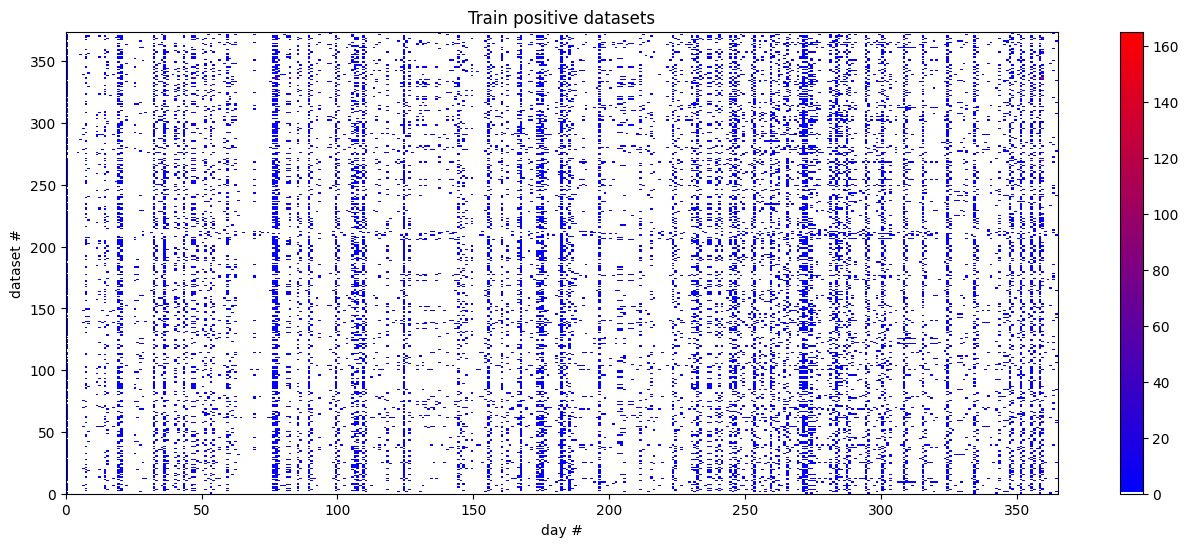

In [38]:
from visualize_heatmap_accesses import plot_heatmap_accesses

plot_heatmap_accesses(
        np.stack(objs_df[objs_df['y'] > 0]['history_ts'].to_numpy()),
        axis=None,
        title='Train positive datasets',
        savefig_path=None
)

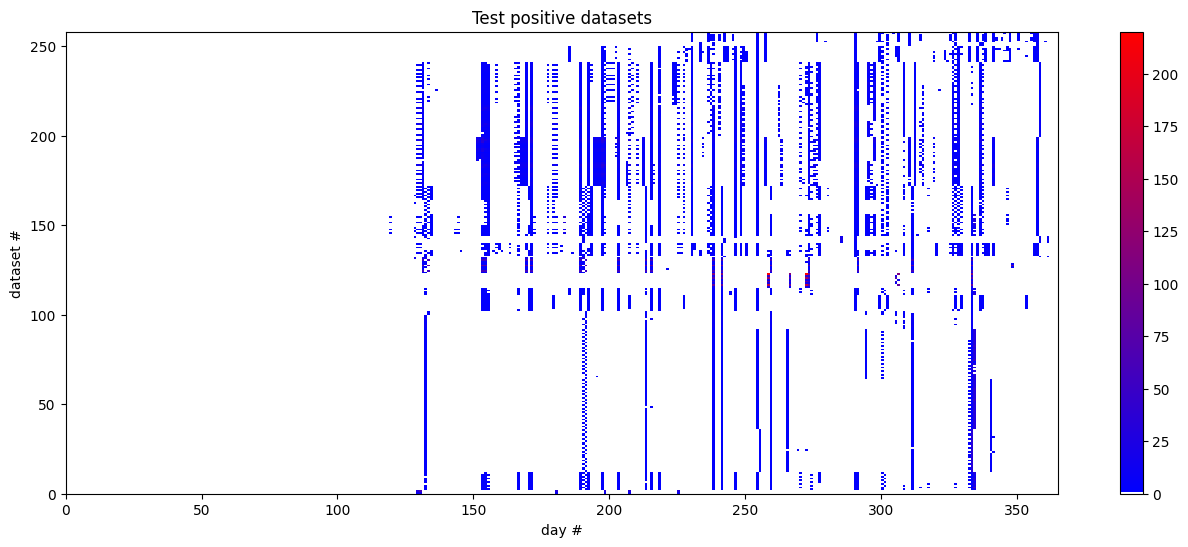

In [39]:
plot_heatmap_accesses(
        np.stack(objs_df_val[objs_df_val['y'] > 0]['history_ts'].to_numpy()),
        axis=None,
        title='Test positive datasets',
        savefig_path=None
)